<a href="https://colab.research.google.com/github/muraryu/dogcat/blob/master/dogcat_mura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Google Colabの場合のみ最初に実行する

ここではGoogleドライブから必要なデータを持ってくる(直接アップロードでも良いが面倒。KaggleAPIキーも面倒。)

In [1]:
# 事前にGoogleドライブに必要なデータを保存しておく
# => train_label.csv, sample_submission.csv, train.zip, test.zip

# Googleドライブのマウント
# 実行後、標準出力のURLをクリックしてアクセス許可＆認証コードを取得し、’Enter your authorization code:’に入力する
from google.colab import drive
drive.mount('/content/drive')

# Googleドライブに保存しておいた重いデータのみローカルにコピー
!cp "drive/My Drive/dogcat/input/train.zip" ./
!cp "drive/My Drive/dogcat/input/test.zip" ./
!cp "drive/My Drive/dogcat/input/original/test_original.zip" ./

# 解凍
# 標準出力を '> /dev/null' で捨てないとブラウザが固まるため注意する
# 同様に解凍後のフォルダを左のファイルビューで展開しないこと(ファイルが多すぎて固まる)
!mkdir ./train
!mkdir ./test
!mkdir ./test_original
!unzip train.zip -d ./train > /dev/null
!unzip test.zip -d ./test > /dev/null
!unzip test_original.zip -d ./test_original > /dev/null

print('done')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
done


In [2]:
# パス　実行環境ごとに書き換え
train_dir = 'train/'
test_dir = 'test/'
test_original_dir = 'test_original/'
train_pre_dir = 'train_pre/'
test_pre_dir = 'test_pre/'
test_original_pre_dir = 'test_original_pre/'
train_labels_path = 'drive/My Drive/dogcat/input/train_label.csv'
sample_submission_path = 'drive/My Drive/dogcat/input/sample_submission.csv'
sample_submission_original_path = 'drive/My Drive/dogcat/input/original/sample_submission_original.csv'
gradcam_dir = 'drive/My Drive/dogcat/GradCAM++/'
model_check_point_dir = 'drive/My Drive/dogcat/model/'

# Google Colaboratory環境であることを示すフラグ
google_colab_flag = []

print('done')

done


##################

**ここからKaggle共通**
##################

In [6]:
# Google Colaboratory環境ではない場合、Kaggleのファイルパスを使用
if 'google_colab_flag' in locals():
    print('Using file path for Google Colaboratory.')
else:
    print('Using file path for Kaggle.')
    train_dir = '../input/train/'
    test_dir = '../input/test/'
    train_pre_dir = '../train_pre/'
    test_pre_dir = '../test_pre/'
    train_labels_path = '../input/train_label.csv'
    sample_submission_path = '../input/sample_submission.csv'
    gradcam_dir = '../GradCAM++'
    model_check_point_dir = './model/'

# %% [markdown]
# 事前に画像サイズを統一しておくことで学習時間を短縮します。 

# %% [markdown]
# ********# Dogs vs Cats Recognition: InClass
# # # # # # # # これは [Dogs vs Cats Recognition: InClass](https://www.kaggle.com/c/dog-cat-recognition/overview)のBase kernelです。  
# # # # # # # # PythonのDeep learning用フレームワーク keras を使用し、基本的なCNNモデルを構築します。  
# # # # # # # # またkerasの ImageDataGenerator を使用し、画像の水増し (Data Augmentation) を行えるようにしているのがポイントです。

# %% [markdown]
# ----
# # # # # # # # Import, Config, Utilities
# # # # # # # # まず初めに下記を行います。
# # # # # # # # - 必要なライブラリのImport
# # # # # # # # - 各種Config (乱数seed設定, 学習パラメタ...etc)
# # # # # # # # - Utility関数の定義

# %% [code]
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
from keras.preprocessing.image import ImageDataGenerator
import random
import keras.backend as K
import tensorflow as tf

import cv2
from PIL import Image

from tqdm import tqdm_notebook as tqdm

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization, Activation
from keras.optimizers import Adam, RMSprop, SGD
from keras.initializers import glorot_uniform

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger, ModelCheckpoint

from IPython.display import HTML
import base64

# 追加
import math
from keras.applications import *
import traceback

# %% [code]
# 関数

# 学習曲線の描画関数
def show_fit_result(history):
    plt.figure(figsize=(16,4))
    
    # plot accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'], label='trn_acc', marker='.')
    plt.plot(history.history['val_acc'], label='val_acc', marker='.')
    plt.title('Accuracy')
    plt.legend()
    
    # plot loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='trn_loss', marker='.')
    plt.plot(history.history['val_loss'], label='val_loss', marker='.')
    plt.title('Crossentropy')
    plt.legend()

def CNN(input_shape, kernel_size, max_pooling_size, act_func, conv2d_filters, drop_ratio, num_layer, num_dence_layer, num_conv2d_layer):
    # input_shape      : 入力次元数 
    # kernel_size      : 畳み込み層のフィルタサイズ
    # max_pooling_size : Pooling層のフィルタサイズ
    # act_func         : 中間層の活性化関数
    # drop_ratio       : Dropoutの割合
    
    # kernel initializers
    gl_init = glorot_uniform(1111)
    
    # Sequentialモデルのインスタンス作成
    model = Sequential()

    """
    for i in range(num_layer):
        for j in range(num_conv2d_layer):
            if i == 0 and j == 0:
                model.add(Conv2D(conv2d_filters, kernel_size, activation='relu', input_shape=input_shape, kernel_initializer=gl_init))
            else:
                model.add(Conv2D(conv2d_filters, kernel_size, activation='relu'))
        model.add(MaxPooling2D(pool_size=max_pooling_size))
        model.add(Dropout(drop_ratio, seed=1111))

    # 2次元-->1次元への変換
    model.add(Flatten())
        
    for i in range(num_dence_layer):
        model.add(Dense(int(1024/(2**i)), activation='relu', kernel_initializer=gl_init))
    # 出力層
    model.add(Dense(1, activation='sigmoid', kernel_initializer=gl_init))
        
    """
    
    """
    model.add(Conv2D(64, kernel_size, activation='relu', padding='same', kernel_initializer=gl_init, input_shape=input_shape))
    model.add(Conv2D(64, kernel_size, activation='relu', padding='same', kernel_initializer=gl_init))
    model.add(MaxPooling2D(pool_size=max_pooling_size))
    model.add(Conv2D(128, kernel_size, activation='relu', padding='same', kernel_initializer=gl_init))
    model.add(Conv2D(128, kernel_size, activation='relu', padding='same', kernel_initializer=gl_init))
    model.add(MaxPooling2D(pool_size=max_pooling_size))
    model.add(Conv2D(256, kernel_size, activation='relu', padding='same', kernel_initializer=gl_init))
    model.add(Conv2D(256, kernel_size, activation='relu', padding='same', kernel_initializer=gl_init))
    model.add(Conv2D(256, 1, activation='relu', padding='same', kernel_initializer=gl_init))
    model.add(MaxPooling2D(pool_size=max_pooling_size))
    model.add(Conv2D(512, kernel_size, activation='relu', padding='same', kernel_initializer=gl_init))
    model.add(Conv2D(512, kernel_size, activation='relu', padding='same', kernel_initializer=gl_init))
    model.add(Conv2D(512, 1, activation='relu', padding='same', kernel_initializer=gl_init))
    model.add(MaxPooling2D(pool_size=max_pooling_size))
    model.add(Conv2D(512, kernel_size, activation='relu', padding='same', kernel_initializer=gl_init))
    model.add(Conv2D(512, kernel_size, activation='relu', padding='same', kernel_initializer=gl_init))
    model.add(Conv2D(512, 1, activation='relu', padding='same', kernel_initializer=gl_init))
    model.add(MaxPooling2D(pool_size=max_pooling_size))
    # 2次元-->1次元への変換
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu', kernel_initializer=gl_init))
    model.add(Dropout(0.5, seed=1111))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=gl_init))
    """
    
    #conv_base = Xception(include_top=False, weights='imagenet', input_shape=input_shape, pooling=None)
    #conv_base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape, pooling=None)
    #conv_base = VGG19(include_top=False, weights='imagenet', input_shape=input_shape, pooling=None)
    #conv_base = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape, pooling=None)
    #conv_base = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape, pooling=None)
    conv_base = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape, pooling=None)
    #conv_base = MobileNet(input_shape=input_shape, alpha=1.0, depth_multiplier=1, dropout=1e-3, include_top=False, weights='imagenet', pooling=None)
    #conv_base = DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape, pooling=None)
    #conv_base = NASNetLarge(input_shape=input_shape, include_top=False, weights='imagenet', pooling=None)
    #conv_base = MobileNetV2(input_shape=input_shape, alpha=1.0, depth_multiplier=1, include_top=False, weights='imagenet', pooling=None)
    
    #conv_base.trainable = False
    model.add(conv_base)
    model.add(Flatten())

#    model.add(Dense(256, activation='relu'))
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dropout(0.5, seed=1111))
    model.add(Dense(1, activation='sigmoid')) 

    
    """
    # 畳み込み層、Pooling層、Dropoutの追加
    model.add(Conv2D(64, kernel_size, padding='same', activation=act_func, input_shape=input_shape, kernel_initializer=gl_init))
    model.add(MaxPool2D(pool_size=max_pooling_size))
    model.add(Dropout(drop_ratio, seed=1111))
    
    # 畳み込み層、Pooling層、Dropoutの追加
    for i in range(num_layer):    
        model.add(Conv2D(64, kernel_size, padding='same', activation=act_func, kernel_initializer=gl_init))
        model.add(MaxPool2D(pool_size=max_pooling_size))
        model.add(Dropout(drop_ratio, seed=1111))

    # 2次元-->1次元への変換
    model.add(Flatten())
    
    # 全結合層の追加
    model.add(Dense(128, activation=act_func, kernel_initializer=gl_init))
    
    # 出力層
    model.add(Dense(1, activation='sigmoid', kernel_initializer=gl_init))
    """
    
    return model
    
def logloss(true_label, predicted, eps=1e-15):
    p = np.clip(predicted, eps, 1 - eps)
    true_label = int(true_label)
    if true_label == 1:
        return -math.log(p)
    else:
        return -math.log(1 - p)

def loglossavg(true_label_ary, predicted_ary):
    s = 0
    i = 0
    print(true_label_ary)
    print(predicted_ary)
    for true_label in true_label_ary:
        s += logloss(true_label, predicted_ary[i])
        i += 1
    return s/i

# (参考)下記関数を使うと、予測結果のCSVファイルをCommitなしで取得できます。
# https://www.kaggle.com/rtatman/download-a-csv-file-from-a-kernel
# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "submission.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)


### **注意**
# # # # # # 上記で乱数seedを固定することで、ある程度は実験の再現性が得られますが、完全ではありません。  
# # # # # # (kernel編集中の学習結果とCommit後の学習結果が微妙に異なる)  
# # # # # # これはNVIDIA製GPUにおける並列計算処理が非決定的であるためです。  
# # # # # # 本kernelの最後にはCommitなしで予測結果のCSVをダウンロードする方法も記載していますので参考にしてください。

# 乱数seedの固定 (kerasの学習結果の再現性確保)
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(1111)
random.seed(1111)

session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

tf.set_random_seed(1111)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# %% [code]
# 変数

value_space = {}

# CNNパラメータ
value_space["CNN_conv2d_filters"] = [4,8,16,32,64,128,192,256,512,1024,2048,4096,8192]
value_space["CNN_num_dence_layer"] = [0,1,2,3,4,5,6,7]
value_space["CNN_num_layer"] = np.arange(0, 11, 1)
value_space["CNN_kernel_size"] = np.arange(1, 11, 1)
value_space["CNN_act_func"] = ["softmax", "elu", "selu", "softplus", "softsign", "relu", "tanh", "sigmoid", "hard_sigmoid", "linear"]
value_space["CNN_max_pooling_size"] = np.arange(2, 11, 1)
value_space["CNN_drop_ratio"] = np.arange(0.0, 1.1, 0.1)
value_space["CNN_num_conv2d_layer"] = [1,2,3,4,5,6,7,8,9,10]

# target size
value_space["width_x_height"] = [32,64,96,128,192,512,320,384,448,512]
value_space["batch_size"] = [8,16,32,48,128,256,512,1024,2048]
value_space["color_mode"] = ["grayscale", "rgb"]

# 学習画像前処理
value_space["rotation_range"] = np.arange(0, 181, 5)
value_space["width_shift_range"] = np.arange(0.0, 1.1, 0.1)
value_space["height_shift_range"] = np.arange(0.0, 1.1, 0.1)
value_space["zoom_range"] = np.arange(0.0, 1.1, 0.1)
value_space["brightness_range"] = np.arange(0.0, 1.1, 0.1)
value_space["fill_mode"] = ["nearest", "reflect", "wrap"]

# ベクトル初期化
candidate_vector = {
    "CNN_conv2d_filters":5,
    "CNN_num_dence_layer":3,
    "CNN_num_layer":4,
    "CNN_kernel_size":2,
    "CNN_act_func":5,
    "CNN_max_pooling_size":0,
    "CNN_drop_ratio":0,
    "CNN_num_conv2d_layer":0,

    "width_x_height":5,
    "batch_size":0,
    "color_mode":1,

    "rotation_range":10,
    "width_shift_range":2,
    "height_shift_range":2,
    "zoom_range":0,
    "brightness_range":5,
    "fill_mode":0,
    }

# 固定変数リスト
fixed_variable = [
    "CNN_conv2d_filters",
    "CNN_num_dence_layer",
    "CNN_num_layer",
    "CNN_kernel_size",
    "CNN_act_func",
    "CNN_max_pooling_size",
    "CNN_drop_ratio",
    "CNN_num_conv2d_layer",

    "width_x_height",
    "batch_size",
    "color_mode",

    "rotation_range",
    "width_shift_range",
    "height_shift_range",
    "zoom_range",
    "brightness_range",
    "fill_mode",
]


# number of epoch
NUM_EPOCH = 0

# %% [code]
# 初回近傍ベクトル
near_vector_array = []

near_vector_array.append(candidate_vector.copy())
for key in candidate_vector:
    if not key in fixed_variable:
        near_vector = candidate_vector.copy()
        near_vector[key] = (near_vector[key] + 1) % len(value_space[key])
        near_vector_array.append(near_vector)

        near_vector = candidate_vector.copy()
        near_vector[key] = (near_vector[key] - 1) % len(value_space[key])
        near_vector_array.append(near_vector)

"""
near_vector_array.append({'CNN_conv2d_filters': 3, 'CNN_num_dence_layer': 3, 'CNN_num_layer': 0, 'CNN_kernel_size': 2, 'CNN_act_func': 5, 'CNN_max_pooling_size': 1, 'CNN_drop_ratio': 10, 'width': 5, 'height': 5, 'batch_size': 2, 'color_mode': 1, 'rotation_range': 0, 'width_shift_range': 0, 'height_shift_range': 0, 'zoom_range': 0, 'brightness_range': 0, 'fill_mode': 0})
near_vector_array.append({'CNN_conv2d_filters': 3, 'CNN_num_dence_layer': 3, 'CNN_num_layer': 0, 'CNN_kernel_size': 2, 'CNN_act_func': 5, 'CNN_max_pooling_size': 1, 'CNN_drop_ratio': 10, 'width': 5, 'height': 5, 'batch_size': 2, 'color_mode': 1, 'rotation_range': 0, 'width_shift_range': 0, 'height_shift_range': 0, 'zoom_range': 0, 'brightness_range': 0, 'fill_mode': 0})
random.shuffle(near_vector_array)
"""
# 最良近傍ベクトルを現在位置で初期化
candidate_vector["evaluation_value"] = 1.0
best_near_vector = candidate_vector.copy()

# %% [markdown]
# ----
# # # # # # # # 近傍解ループ　ここから

# %% [code]
CNN_model = None
while(True):
    print("####################################################################################################")
    for near_vector in near_vector_array:
        print(near_vector)
            
    for near_vector in near_vector_array:
        print("--------------------------------------------------------------------------------------------------")
        print(near_vector)

        # %% [markdown]
        # ----
        # Create model

        # %% [code]
        # optimizerの初期化
        #optimizer = Adam(lr=0.0001)
        #optimizer = RMSprop(lr=2e-5) #, decay=1e-3)
        #optimizer = SGD(lr=2e-5, momentum=0.9, decay=1e-6, nesterov=True)
        optimizer = SGD(lr=1e-4, momentum=0.9)
        
        # モデルの定義
        if value_space["color_mode"][near_vector["color_mode"]] == "grayscale":
            num_color = 1
        else:
            num_color = 3
        try:
            CNN_model = CNN(input_shape=(value_space["width_x_height"][near_vector["width_x_height"]],value_space["width_x_height"][near_vector["width_x_height"]],num_color),
                            kernel_size=(value_space["CNN_kernel_size"][near_vector["CNN_kernel_size"]],value_space["CNN_kernel_size"][near_vector["CNN_kernel_size"]]),
                            max_pooling_size=(value_space["CNN_max_pooling_size"][near_vector["CNN_max_pooling_size"]],value_space["CNN_max_pooling_size"][near_vector["CNN_max_pooling_size"]]),
                            act_func=value_space["CNN_act_func"][near_vector["CNN_act_func"]],
                            drop_ratio=value_space["CNN_drop_ratio"][near_vector["CNN_drop_ratio"]],
                            num_layer=value_space["CNN_num_layer"][near_vector["CNN_num_layer"]],
                            conv2d_filters=value_space["CNN_conv2d_filters"][near_vector["CNN_conv2d_filters"]],
                            num_dence_layer=value_space["CNN_num_dence_layer"][near_vector["CNN_num_dence_layer"]],
                            num_conv2d_layer=value_space["CNN_num_conv2d_layer"][near_vector["CNN_num_conv2d_layer"]],
                           )
        except Exception as e:
            print("Skipped as ValueError was raised at CNN().")
            import traceback
            traceback.print_exc()
        
        # モデルのコンパイル
        CNN_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        # モデル情報を表示
        CNN_model.summary()
        
        if not NUM_EPOCH == 0:
            # %% [code]
            # 画像ファイル名, label情報の取得
            train_df = pd.read_csv(train_labels_path, dtype='str')
    #        display(train_df.head())
            train_preprocessed_dir = train_pre_dir
            os.makedirs(train_preprocessed_dir, exist_ok=True)
            for path in tqdm(train_df['filename']):
                img = Image.open(train_dir + path)
                img = img.resize((value_space["width_x_height"][near_vector["width_x_height"]], value_space["width_x_height"][near_vector["width_x_height"]]))
                img.save(train_preprocessed_dir + path)

            # %% [code]
            #-----------------------------------------------#
            # ImageDataGenerator
            #   - 画像の読み込み & 水増し(Data Augmentation)
            #   - 学習時にリアルタイムにファイルからデータ読み込み
            #     →Data Augmentationを行う
            #   - Augmentationをリアルタイムに行うのでメモリを圧迫しない
            #   - どのような変換をするかはインスタンス生成時に指定する
            #-----------------------------------------------#

            # trainデータ用インスタンス生成
            train_datagen = ImageDataGenerator(
                rescale=1. / 255,              # 画像の正規化
    #            rotation_range=value_space["rotation_range"][near_vector["rotation_range"]],             # ランダムに画像を回転 (単位：度)
    #            width_shift_range=value_space["width_shift_range"][near_vector["width_shift_range"]],        # ランダムに画像を水平シフト (画像横幅に対する割合を指定)
    #            height_shift_range=value_space["height_shift_range"][near_vector["height_shift_range"]],       # ランダムに画像を垂直シフト (画像縦幅に対する割合を指定)
    #            zoom_range=[1.0-value_space["zoom_range"][near_vector["zoom_range"]], 1.0+value_space["zoom_range"][near_vector["zoom_range"]]],        # ランダムに画像を拡縮 (下限, 上限)
    #            horizontal_flip=True,         # ランダムに画像を左右反転
    #            vertical_flip=False,           # ランダムに画像を上下反転
    #            brightness_range=[1.0-value_space["brightness_range"][near_vector["brightness_range"]], 1.0+value_space["brightness_range"][near_vector["brightness_range"]]],  # ランダムに画像を輝度変換 (下限, 上限)
    #            fill_mode=value_space["fill_mode"][near_vector["fill_mode"]],          # 画像変換時に生じた空白部分の埋め方 (nearestは近傍値で埋める)
                validation_split = 0.3         # validationデータの割合
                )

            # %% [markdown]
            # 参考リンク
            # # - [ImageDataGenerator｜Keras公式ドキュメント](https://keras.io/ja/preprocessing/image/)  
            # # - [Kerasによるデータ拡張｜人工知能に関する断創録](http://aidiary.hatenablog.com/entry/20161212/1481549365)

            # %% [code]
            #-----------------------------------------------#
            # ImageDataGenerator.flow_from_dataframe
            #   - DataFrameからデータ生成用ジェネレーター作成
            #
            #     dataframe  : 読み込むDataFrame
            #     directory  : 元画像が格納されているディレクトリ名
            #     x_col      : 画像名を表すcolumn
            #     y_col      : ラベルを表すcolumn
            #     target_size: 指定した画像サイズにリサイズする
            #     batch_size : 学習時のミニバッチサイズ
            #     class_mode : 問題設定  'binary'=二値分類
            #     shuffle    : 画像読み込み順をシャッフルする
            #     seed       : 乱数シード値
            #     subset     : trainデータかvalidデータかを指定
            #-----------------------------------------------#

            # trainデータ用ジェネレーター
            train_generator = train_datagen.flow_from_dataframe(
                        dataframe=train_df,
                        directory=train_preprocessed_dir,
                        x_col='filename',
                        y_col='label',
                        target_size=(value_space["width_x_height"][near_vector["width_x_height"]],value_space["width_x_height"][near_vector["width_x_height"]]),
                        batch_size=value_space["batch_size"][near_vector["batch_size"]],
                        color_mode=value_space["color_mode"][near_vector["color_mode"]],
                        class_mode='binary',
                        shuffle=True,
                        seed=1111,
                        subset = "training"
                    )

            # validデータ用ジェネレーター
            val_generator = train_datagen.flow_from_dataframe(
                        dataframe=train_df,
                        directory=train_preprocessed_dir,
                        x_col='filename',
                        y_col='label',
                        target_size=(value_space["width_x_height"][near_vector["width_x_height"]],value_space["width_x_height"][near_vector["width_x_height"]]),
                        batch_size=value_space["batch_size"][near_vector["batch_size"]],
                        color_mode=value_space["color_mode"][near_vector["color_mode"]],
                        class_mode='binary',
                        shuffle=True,
                        seed=1111,
                        subset = "validation"
                    )

            # %% [code]
            # 各Epoch終了時に呼び出すcallback
            callbacks = []

            # 学習ログをCSVに書き出す
            callbacks.append(CSVLogger('history.csv'))

            # --過学習防止用callback--
            # patienceで指定したEpochの間, monitorの値が改善しなければ学習を打ち切る
            #callbacks.append(EarlyStopping(patience=8, monitor='val_acc'))

            # --学習率スケジューリング用callback--
            # patienceで指定したEpochの間, monitorの値が改善しなければ
            # 現在の学習率にfactorをかけて学習を継続する
            callbacks.append(ReduceLROnPlateau(patience=3, monitor='val_acc',
                                              factor=0.5, min_lr=1e-5, verbose=1))

            # --エポックごとに経過保存callback--
            os.makedirs(model_check_point_dir, exist_ok=True)
            callbacks.append(ModelCheckpoint(filepath = os.path.join(model_check_point_dir,'cnn_model-epoch{epoch:02d}-loss{loss:.4f}-acc{acc:.4f}-vloss{val_loss:.4f}-vacc{val_acc:.4f}.hdf5'), monitor='val_loss', verbose=1, save_best_only=False, mode='auto'))

        # 重みロード
        weight_path = '/content/drive/My Drive/dogcat/model/cnn_model-epoch06-loss0.0244-acc0.9949-vloss0.0114-vacc0.9959.hdf5'
        CNN_model.load_weights(weight_path)
        print('Using weight file : ' + weight_path)

        if NUM_EPOCH == 0:
            print('break without fit (NUM_EPOCH == 0)')
            break

        # %% [code]
        # 学習の実施
        try:
            history = CNN_model.fit_generator(
                train_generator,
                steps_per_epoch=len(train_generator),
                epochs=NUM_EPOCH,
                validation_data=val_generator,
                validation_steps=len(val_generator),
                callbacks=callbacks,
                verbose=1
            )
        except Exception as e:
            print("Skipped as ValueError was raised at CNN_model.fit_generator()")
            traceback.print_exc()
            continue

        # 学習結果の表示
        show_fit_result(history)

        # 現在の解ベクトル評価

        # 検証データのLogLoss平均を取得して評価値とする
        loss, acc = CNN_model.evaluate_generator(val_generator, steps=len(val_generator), verbose=1)
        print('Test loss: %s, Test acc: %s' % (loss, acc))
        near_vector["evaluation_value"] = loss

        # LogLoss平均
        #print(loglossavg(train_df['label'].as_matrix(),preds))

        # 最良の近傍解と比較
        if near_vector["evaluation_value"] < best_near_vector["evaluation_value"]:
            best_near_vector = near_vector.copy()

        print("Best near vector=")
        print(best_near_vector)
        print("Candidate vector=")
        print(candidate_vector)
        
        
    # 現在のベクトルより良い近傍ベクトルがあれば移動し、なければ終了
    if best_near_vector["evaluation_value"] < candidate_vector["evaluation_value"]:
        print("Better vector found.")
        # 移動先の近傍ベクトルのリストを生成
        near_vector_array = []
        for key in best_near_vector:
            if key == "evaluation_value":
                    continue
            if not key in fixed_variable:
                near_vector = best_near_vector.copy()
                near_vector[key] = (near_vector[key] + 1) % len(value_space[key])
                near_vector_array.append(near_vector)

                near_vector = best_near_vector.copy()
                near_vector[key] = (near_vector[key] - 1) % len(value_space[key])
                near_vector_array.append(near_vector)

        # 前回の解候補を除外
        index = 0
        for near_vector in near_vector_array:
            if near_vector == candidate_vector:
                near_vector_array.remove(index)
                break
            index += 1
        
        # 移動
        candidate_vector = best_near_vector.copy()
        
        
    else:
        # 最適化終了
        break

# %% [markdown]
# # 近傍解ループここまで
# # # # # # # ----

# %% [code]
#最適ベクトルで100エポックで再学習

Using file path for Google Colaboratory.
####################################################################################################
{'CNN_conv2d_filters': 5, 'CNN_num_dence_layer': 3, 'CNN_num_layer': 4, 'CNN_kernel_size': 2, 'CNN_act_func': 5, 'CNN_max_pooling_size': 0, 'CNN_drop_ratio': 0, 'CNN_num_conv2d_layer': 0, 'width_x_height': 5, 'batch_size': 0, 'color_mode': 1, 'rotation_range': 10, 'width_shift_range': 2, 'height_shift_range': 2, 'zoom_range': 0, 'brightness_range': 5, 'fill_mode': 0}
--------------------------------------------------------------------------------------------------
{'CNN_conv2d_filters': 5, 'CNN_num_dence_layer': 3, 'CNN_num_layer': 4, 'CNN_kernel_size': 2, 'CNN_act_func': 5, 'CNN_max_pooling_size': 0, 'CNN_drop_ratio': 0, 'CNN_num_conv2d_layer': 0, 'width_x_height': 5, 'batch_size': 0, 'color_mode': 1, 'rotation_range': 10, 'width_shift_range': 2, 'height_shift_range': 2, 'zoom_range': 0, 'brightness_range': 5, 'fill_mode': 0}
Model: "sequential_

Creating submission.csv...



Found 8000 validated image filenames.
1000/1000 [==============================] - 692s 692ms/step
1000
      filename         label
0        1.jpg  9.999478e-01
1        2.jpg  7.313490e-05
2        3.jpg  3.735423e-04
3        4.jpg  9.998533e-01
4        5.jpg  2.205968e-04
5        6.jpg  1.966953e-05
6        7.jpg  6.293356e-04
7        8.jpg  9.999124e-01
8        9.jpg  9.998723e-01
9       10.jpg  9.998448e-01
10      11.jpg  9.993954e-01
11      12.jpg  2.169013e-04
12      13.jpg  9.997271e-01
13      14.jpg  9.998951e-01
14      15.jpg  6.984532e-03
15      16.jpg  9.995326e-01
16      17.jpg  9.998963e-01
17      18.jpg  9.994366e-01
18      19.jpg  1.907349e-06
19      20.jpg  1.871288e-04
20      21.jpg  2.346784e-03
21      22.jpg  2.682209e-07
22      23.jpg  9.998519e-01
23      24.jpg  9.997010e-01
24      25.jpg  9.995033e-01
25      26.jpg  2.934039e-04
26      27.jpg  9.999418e-01
27      28.jpg  3.603399e-04
28      29.jpg  7.331371e-06
29      30.jpg  2.393126e

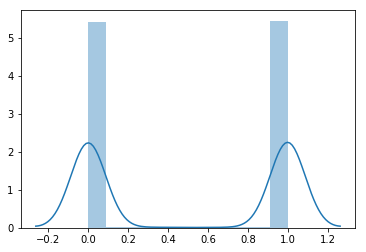

In [8]:
#テストデータ予測＆submissionファイル作成
print('Creating submission.csv...')

# testデータ読み込み
test_df = pd.read_csv(sample_submission_path, dtype='str')
#display(test_df.head())
test_preprocessed_dir = test_pre_dir
os.makedirs(test_preprocessed_dir, exist_ok=True)

# testデータ前処理
for path in tqdm(test_df['filename']):
    img = Image.open(test_dir + path)

    # 正方形になるように余白追加
    width, height = img.size
    if height == width:
        #print('height == width')
        pass
    elif height > width:
        #print('height > width')
        img = img.crop((-(height-width)/2, 0, width+(height-width)/2, height))
    else:
        #print('height < width')
        img = img.crop((0, -((width-height)/2), width, height+(width-height)/2))

    img = img.resize((value_space["width_x_height"][near_vector["width_x_height"]], value_space["width_x_height"][near_vector["width_x_height"]]))
    img.save(test_preprocessed_dir + path)

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory=test_preprocessed_dir,
            x_col='filename',
            y_col=None,
            target_size=(value_space["width_x_height"][candidate_vector["width_x_height"]],value_space["width_x_height"][candidate_vector["width_x_height"]]),
            batch_size=value_space["batch_size"][candidate_vector["batch_size"]],
            color_mode=value_space["color_mode"][candidate_vector["color_mode"]],
            class_mode=None,
            shuffle=False,
            seed=1111
        )

# テストデータ予測
preds = CNN_model.predict_generator(test_generator, steps=len(test_generator), verbose=1)
print(len(test_generator))

# testデータ予測結果の表示
sns.distplot(np.reshape(preds, (-1,)))

# submissionファイルの生成
submission = pd.read_csv(sample_submission_path)
submission['label'] = np.reshape(preds, (-1,))
submission.to_csv('submission.csv', index=False)
print(submission)
#submission.head()

# (参考)CSVダウンロードリンクの生成
create_download_link(submission)

# %% [code]
# (参考)CSVダウンロードリンクの生成
create_download_link(submission)

# %% [code]
import shutil
#shutil.rmtree(train_preprocessed_dir)
#shutil.rmtree(test_preprocessed_dir)# %% [markdown]

In [9]:
# Binning & 確信度が低いファイル名表示
import csv

outary = []
with open('submission.csv', 'r') as fin:
  reader = csv.reader(fin)
  header = next(reader)
  outary.append(header)

  b0 = 0
  b1 = 0
  b2 = 0
  for row in reader:
    if float(row[1]) > 0.01 and float(row[1]) < 0.99 :
      b0 += 1
      print(str(b0), ' : ', row)
      row[1] = 0.5
    elif float(row[1]) <= 0.01:
      row[1] = 0.0001 # 0にして間違うとLogLoss無限になる
    else:
      row[1] = 0.9999 # 1にして間違うとLogLoss無限になる
#   print(row[1])
    outary.append(row)	

with open('submission_step.csv', 'w') as fout:
    writer = csv.writer(fout, lineterminator='\n')
    writer.writerows(outary)
fout.close()

1  :  ['37.jpg', '0.012360454']
2  :  ['46.jpg', '0.6473928']
3  :  ['50.jpg', '0.40584067']
4  :  ['71.jpg', '0.6756677']
5  :  ['99.jpg', '0.9382951']
6  :  ['101.jpg', '0.01989019']
7  :  ['184.jpg', '0.21328014']
8  :  ['243.jpg', '0.15713069']
9  :  ['256.jpg', '0.9053858']
10  :  ['265.jpg', '0.021847606']
11  :  ['284.jpg', '0.9878462']
12  :  ['320.jpg', '0.9741235']
13  :  ['330.jpg', '0.017485052']
14  :  ['346.jpg', '0.012344986']
15  :  ['350.jpg', '0.40425736']
16  :  ['356.jpg', '0.9794556']
17  :  ['370.jpg', '0.97442317']
18  :  ['403.jpg', '0.05425766']
19  :  ['472.jpg', '0.9895323']
20  :  ['501.jpg', '0.16289392']
21  :  ['534.jpg', '0.31804872']
22  :  ['538.jpg', '0.9888081']
23  :  ['559.jpg', '0.2628387']
24  :  ['586.jpg', '0.98015976']
25  :  ['623.jpg', '0.166821']
26  :  ['643.jpg', '0.82261634']
27  :  ['657.jpg', '0.74963045']
28  :  ['792.jpg', '0.03679678']
29  :  ['797.jpg', '0.25998196']
30  :  ['816.jpg', '0.9888871']
31  :  ['835.jpg', '0.31183612']


Heat Map
prob =  0.000100223006


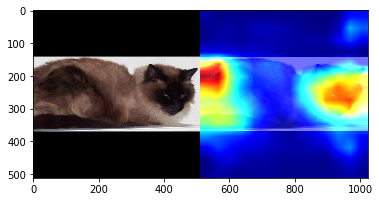

In [26]:
# Grad-CAM++による判断根拠可視化
# CNNの最終畳み込み層を指定する必要あり
# 事前にCNN_modelに学習済みCNNモデルを入れておく
# 以下は活性化関数が２階微分で０になることが前提
# https://qiita.com/Dason08/items/a8013b3fa4d303f5c41c
import pandas as pd
import numpy as np
import cv2
import argparse
import keras
import time
import sys
from keras import backend as K
from keras.preprocessing.image import array_to_img, img_to_array, load_img

K.set_learning_phase(1)

def Grad_Cam_plus_plus(input_model, layer_name, x, row, col):
    '''
    Args:
       input_model: ResNet50のモデル
       x: 画像(array)
       layer_name: 畳み込み層の名前
       (row, col): 画像のサイズ
    Returns:
       jetcam: 影響の大きい箇所を色付けした画像(array)
    '''

    model = input_model

    #前処理
    X = np.expand_dims(x, axis=0)
    X = X.astype('float32')
    preprocessed_input = X / 255.0


    #予測クラスの算出
    predictions = model.predict(preprocessed_input)
    class_idx = np.argmax(predictions[0])

    #使用する重みの抽出、高階微分の計算
    class_output = model.layers[-1].output
    conv_output = model.get_layer(layer_name).get_output_at(1) # ImageNetのInceptionResNetV2の場合は1
    grads = K.gradients(class_output, conv_output)[0]
    #first_derivative：１階微分
    first_derivative = K.exp(class_output)[0][class_idx] * grads
    #second_derivative：２階微分
    second_derivative = K.exp(class_output)[0][class_idx] * grads * grads
    #third_derivative：３階微分
    third_derivative = K.exp(class_output)[0][class_idx] * grads * grads * grads

    #関数の定義
    gradient_function = K.function([model.input], [conv_output, first_derivative, second_derivative, third_derivative])  # model.inputを入力すると、conv_outputとgradsを出力する関数


    conv_output, conv_first_grad, conv_second_grad, conv_third_grad = gradient_function([preprocessed_input])
    conv_output, conv_first_grad, conv_second_grad, conv_third_grad = conv_output[0], conv_first_grad[0], conv_second_grad[0], conv_third_grad[0]

    #alphaを求める
    global_sum = np.sum(conv_output.reshape((-1, conv_first_grad.shape[2])), axis=0)
    alpha_num = conv_second_grad
    alpha_denom = conv_second_grad*2.0 + conv_third_grad*global_sum.reshape((1,1,conv_first_grad.shape[2]))
    alpha_denom = np.where(alpha_denom!=0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num / alpha_denom

    #alphaの正規化
    alpha_normalization_constant = np.sum(np.sum(alphas, axis = 0), axis = 0)
    alpha_normalization_constant_processed = np.where(alpha_normalization_constant != 0.0, alpha_normalization_constant, np.ones(alpha_normalization_constant.shape))
    alphas /= alpha_normalization_constant_processed.reshape((1,1,conv_first_grad.shape[2]))

    #wの計算
    weights = np.maximum(conv_first_grad, 0.0)
    deep_linearization_weights = np.sum((weights * alphas).reshape((-1, conv_first_grad.shape[2])))

    #Lの計算
    grad_CAM_map = np.sum(deep_linearization_weights * conv_output, axis=2)
    grad_CAM_map = np.maximum(grad_CAM_map, 0)
    grad_CAM_map = grad_CAM_map / np.max(grad_CAM_map)

    #ヒートマップを描く
    grad_CAM_map = cv2.resize(grad_CAM_map, (row, col), cv2.INTER_LINEAR)
    jetcam = cv2.applyColorMap(np.uint8(255 * grad_CAM_map), cv2.COLORMAP_JET)  # モノクロ画像に疑似的に色をつける
    jetcam = (np.float32(jetcam) + x / 2)   # もとの画像に合成

    return jetcam

#image_path = test_pre_dir + '493.jpg' # Target image file path
#image_path = './train/cat.4289.jpg'
image_path = './crop.jpg'
#image_path = './drive/My Drive/dogcat/input/20190614182430.JPG'

target_layer = 'inception_resnet_v2' # InceptionResNetV2
row = value_space["width_x_height"][near_vector["width_x_height"]]
col = value_space["width_x_height"][near_vector["width_x_height"]]

img = img_to_array(load_img(image_path,target_size=(row,col)))
img_GCAMplusplus = Grad_Cam_plus_plus(CNN_model, target_layer, img, row, col)
time = time.ctime()
img_Gplusplusname = gradcam_dir +os.path.basename(image_path) + "_GCAM++.jpg"
os.makedirs(gradcam_dir, exist_ok=True)
cv2.imwrite(img_Gplusplusname, img_GCAMplusplus)

def hconcat_resize_min(im_list, interpolation=cv2.INTER_CUBIC):
    h_min = min(im.shape[0] for im in im_list)
    im_list_resize = [cv2.resize(im, (int(im.shape[1] * h_min / im.shape[0]), h_min), interpolation=interpolation)
                      for im in im_list]
    return cv2.hconcat(im_list_resize)

original_image = cv2.cvtColor(cv2.resize(cv2.imread(image_path), (row,col)), cv2.COLOR_BGR2RGB)
gradcam_image = cv2.cvtColor(cv2.imread(img_Gplusplusname), cv2.COLOR_BGR2RGB)
im_h_resize = hconcat_resize_min([original_image, gradcam_image])
plt.imshow(im_h_resize)
print('Heat Map')

# 予測
img_predict = []
try:
    img = Image.open(image_path)  # 画像読み込み
    img = img.convert("RGB")
    img = img.resize((row, col))  # 画像のリサイズ
    img_array = np.asarray(img)
    img_predict.append(img_array)
except Exception as e:
    pass
img_predict = np.asarray(img_predict) / 255.
result_predict = CNN_model.predict(img_predict)
print('prob = ', result_predict[0][0])

In [0]:
# 転移学習の場合は以下を実行して最後の方の畳み込み層を見つける
print(CNN_model.get_layer('inception_resnet_v2').get_output_at(1))

In [0]:
# モデル保存
CNN_model.save('drive/My Drive/dogcat/model/cnn_model-')
print('done')

In [12]:
# 二つの結果ファイルのエントロピーが低い項目を採用してファイル出力
submission1_path = 'submission (1).csv'
submission2_path = 'submission_original.csv'

import csv

outary = []

data_array = []
data = []

with open(submission1_path, 'r') as fin:
	  reader = csv.reader(fin)
	  header = next(reader)
	  outary.append(header)
	  for row in reader:
		    data.append(row)

data_array.append(data)
data = []

with open(submission2_path, 'r') as fin:
    reader = csv.reader(fin)
    header = next(reader)
    for row in reader:
        data.append(row)

data_array.append(data)

'''
for irow in range(len(data)):
    max_conf = 0.
    max_data_row = None
    for temp_data in data_array:
        if abs(float(temp_data[irow][1]) - 0.5) >= max_conf:
            max_conf = abs(float(temp_data[irow][1]) - 0.5)
            max_data_row = temp_data[irow]
    outary.append(max_data_row)
'''

count = 0
data_priority = 0
for irow in range(len(data)):
    row = data_array[data_priority][irow]
    if float(row[1]) > 0.01 and float(row[1]) < 0.99 :
      count += 1
      print(str(count), ' : ', row)
      row[1] = (float(row[1]) + float(data_array[data_priority+1][irow][1]))/2
      print(str(count), ' : ', row)
    outary.append(row)

with open('submission_merge.csv', 'w') as fout:
    writer = csv.writer(fout, lineterminator='\n')
    writer.writerows(outary)
fout.close()

print('done')

1  :  ['32', '0.28558418']
1  :  ['32', 0.37741612]
2  :  ['126', '0.76293635']
2  :  ['126', 0.857137825]
3  :  ['138', '0.95286965']
3  :  ['138', 0.919654975]
4  :  ['200', '0.97386134']
4  :  ['200', 0.9629854]
5  :  ['232', '0.04573214']
5  :  ['232', 0.03737624]
6  :  ['277', '0.98182476']
6  :  ['277', 0.982995215]
7  :  ['332', '0.9734849']
7  :  ['332', 0.98018558]
8  :  ['344', '0.14101925']
8  :  ['344', 0.27431315]
9  :  ['392', '0.943437']
9  :  ['392', 0.9688956]
10  :  ['409', '0.014187455']
10  :  ['409', 0.0084768235]
11  :  ['419', '0.9802191']
11  :  ['419', 0.989534365]
12  :  ['434', '0.1499281']
12  :  ['434', 0.13678113]
13  :  ['477', '0.021683842']
13  :  ['477', 0.105589346]
14  :  ['489', '0.8577832']
14  :  ['489', 0.5030679]
15  :  ['527', '0.97817945']
15  :  ['527', 0.986207375]
16  :  ['557', '0.94920695']
16  :  ['557', 0.96446824]
17  :  ['576', '0.014116585']
17  :  ['576', 0.0266059635]
18  :  ['636', '0.98729134']
18  :  ['636', 0.9751882000000001]


Creating submission_original.csv...



Found 12500 validated image filenames.
1563/1563 [==============================] - 1069s 684ms/step
1563
        filename         label
0          1.jpg  9.998742e-01
1          2.jpg  9.999820e-01
2          3.jpg  9.998421e-01
3          4.jpg  9.998447e-01
4          5.jpg  2.803802e-04
5          6.jpg  2.396107e-05
6          7.jpg  4.780293e-05
7          8.jpg  1.270473e-04
8          9.jpg  1.563728e-04
9         10.jpg  2.437830e-05
10        11.jpg  5.844831e-04
11        12.jpg  9.990628e-01
12        13.jpg  1.737475e-05
13        14.jpg  6.258488e-07
14        15.jpg  9.847283e-04
15        16.jpg  2.592802e-06
16        17.jpg  9.970008e-01
17        18.jpg  9.996119e-01
18        19.jpg  4.994869e-05
19        20.jpg  2.631545e-05
20        21.jpg  9.998053e-01
21        22.jpg  0.000000e+00
22        23.jpg  9.998752e-01
23        24.jpg  9.997718e-01
24        25.jpg  5.346537e-05
25        26.jpg  9.968204e-01
26        27.jpg  9.999090e-01
27        28.jpg  1.99675

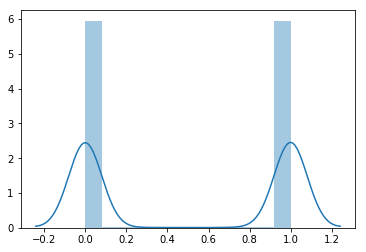

In [12]:
#本家テストデータ予測＆submissionファイル作成
print('Creating submission_original.csv...')

# 本家testデータ読み込み
test_original_df = pd.read_csv(sample_submission_original_path, dtype='str')
#display(test_df.head())
test_original_preprocessed_dir = test_original_pre_dir
os.makedirs(test_original_preprocessed_dir, exist_ok=True)

# 本家testデータ前処理
for path in tqdm(test_original_df['filename']):
    img = Image.open(test_original_dir + path)

    # 正方形になるように余白追加
    width, height = img.size
    if height == width:
        #print('height == width')
        pass
    elif height > width:
        #print('height > width')
        img = img.crop((-(height-width)/2, 0, width+(height-width)/2, height))
    else:
        #print('height < width')
        img = img.crop((0, -((width-height)/2), width, height+(width-height)/2))

    img = img.resize((value_space["width_x_height"][near_vector["width_x_height"]], value_space["width_x_height"][near_vector["width_x_height"]]))
    img.save(test_original_preprocessed_dir + path)

test_original_datagen = ImageDataGenerator(rescale=1. / 255)
test_original_generator = test_original_datagen.flow_from_dataframe(
            dataframe=test_original_df,
            directory=test_original_preprocessed_dir,
            x_col='filename',
            y_col=None,
            target_size=(value_space["width_x_height"][candidate_vector["width_x_height"]],value_space["width_x_height"][candidate_vector["width_x_height"]]),
            batch_size=value_space["batch_size"][candidate_vector["batch_size"]],
            color_mode=value_space["color_mode"][candidate_vector["color_mode"]],
            class_mode=None,
            shuffle=False,
            seed=1111
        )

# 本家テストデータ予測
preds = CNN_model.predict_generator(test_original_generator, steps=len(test_original_generator), verbose=1)
print(len(test_original_generator))

# 本家testデータ予測結果の表示
sns.distplot(np.reshape(preds, (-1,)))

# submissionファイルの生成
submission_original = pd.read_csv(sample_submission_original_path)
submission_original['label'] = np.reshape(preds, (-1,))
submission_original.to_csv('submission_original.csv', index=False)
print(submission_original)
#submission.head()

# (参考)CSVダウンロードリンクの生成
create_download_link(submission_original)

# %% [code]
# (参考)CSVダウンロードリンクの生成
create_download_link(submission_original)

# %% [code]
import shutil
#shutil.rmtree(train_preprocessed_dir)
#shutil.rmtree(test_original_preprocessed_dir)# %% [markdown]

(499, 223)
height < width
(499, 499)


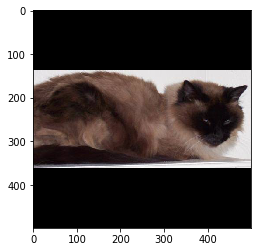

In [25]:
# 画像読み込み
img = Image.open("train/cat.4289.jpg")
width, height = img.size
print(img.size)

# img[top : bottom, left : right]
# サンプル1の切り出し、保存
img1 = None
if height == width:
    print('height == width')
    img1 = img
elif height > width:
    print('height > width')
    img1 = img.crop((-(height-width)/2, 0, width+(height-width)/2, height))
else:
    print('height < width')
    img1 = img.crop((0, -((width-height)/2), width, height+(width-height)/2))
img1.save("crop.jpg")
plt.imshow(np.array(img1))
print(img1.size)